# Lab03 - Post-Processing Kinematic GNSS

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# Problem 2 a
Comparing PPK corrected points and original survey points

In [16]:
pts_original_df = pd.read_csv('../data/lab03/Lab02-RainierVista-RTK-survey_original.csv')
pts_corrected_df = pd.read_csv('../data/lab03/Lab02-RainierVista-RTK-survey_corrected.csv')
# build geopandas points for OPUS with z values from first three columns
pts_original = gpd.points_from_xy(pts_original_df['Longitude'], pts_original_df['Latitude'], pts_original_df['Ellipsoidal height'])
pts_corrected = gpd.points_from_xy(pts_corrected_df['Longitude'], pts_corrected_df['Latitude'], pts_corrected_df['Ellipsoidal height'])
# build geopandas dataframes
pts_original_gdf = gpd.GeoDataFrame(pts_original_df, geometry=pts_original, crs=4326)
pts_original_gdf.to_crs(32610, inplace=True)
pts_corrected_gdf = gpd.GeoDataFrame(pts_corrected_df, geometry=pts_corrected, crs=4326)
pts_corrected_gdf.to_crs(32610, inplace=True)


Map the points

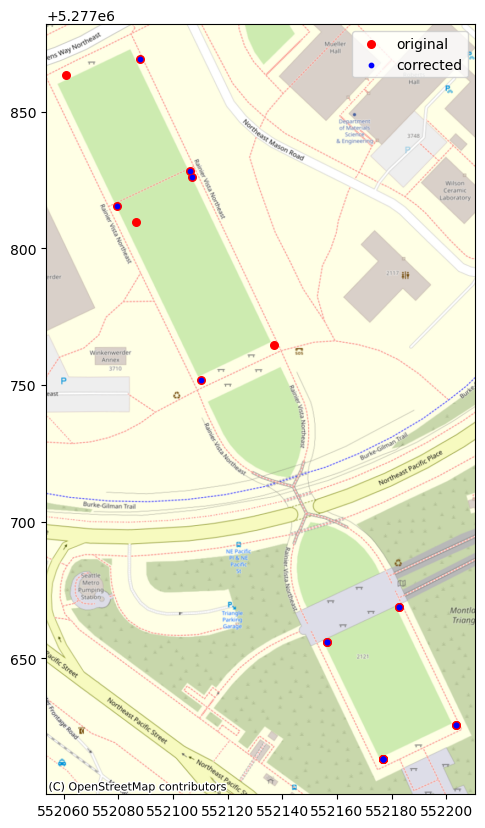

In [17]:
# create a plot of the x,y points with axes units of meters
fig, ax = plt.subplots(figsize=(10,10))

pts_original_gdf.plot(ax=ax, markersize=30, color='red', label='original')
pts_corrected_gdf.plot(ax=ax, markersize=10, color='blue', label='corrected')
ax.legend()
# add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto', crs='EPSG:32610')

Calculate the area of the montlake traingle grass using corrected points

In [20]:
from shapely.geometry import Polygon

In [48]:
montlake_triangle_corners = pts_corrected_gdf.loc[3:6]
# save this as a geojson
montlake_triangle_corners.to_file('../data/lab03/montlake_triangle_corners.geojson', driver='GeoJSON')

In [55]:
montlake_triangle_corners = pts_corrected_gdf.loc[3:6].reset_index()
montlake_triangle_corners_shifted = montlake_triangle_corners.shift(1)
montlake_triangle_corners_shifted.loc[0] = montlake_triangle_corners.iloc[-1]
# generate a polygon from the triangle corners
montlake_triangle = Polygon(zip(montlake_triangle_corners['geometry'].x.to_list(), montlake_triangle_corners['geometry'].y.to_list()))
# add to a geoseries
montlake_triangle_gs = gpd.GeoSeries(montlake_triangle, crs=32610)
print('Area of the grass (m^2):)')
print(montlake_triangle_gs.area.iloc[0])

# print the length of each side of the polygon
print('Lengths of the sides (m):')
for i in montlake_triangle_corners.index:
    print(montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[i])


Area of the grass (m^2):)
1393.5779317874237
Lengths of the sides (m):
47.6370311724076
29.2825714284706
47.66582942327351
29.20796016268232


c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 10N (the single non-null crs provided).
  warnings.warn(


In [67]:
import math
import numpy as np
# calculate the cartographical azimuth from 2 points
dx = montlake_triangle_corners.iloc[2]['geometry'].x - montlake_triangle_corners.iloc[1]['geometry'].x
dy = montlake_triangle_corners.iloc[2]['geometry'].y - montlake_triangle_corners.iloc[1]['geometry'].y

print('Cartographical azimuth (degrees):')
print(360+math.degrees(math.atan2(dx, dy)))

Cartographical azimuth (degrees):
334.28213517606554


In [75]:
# calculate the height difference slope between the corners
west_diff = np.abs(montlake_triangle_corners.iloc[2]['Ellipsoidal height']) - np.abs(montlake_triangle_corners.iloc[1]['Ellipsoidal height'])
east_diff = np.abs(montlake_triangle_corners.iloc[3]['Ellipsoidal height']) - np.abs(montlake_triangle_corners.iloc[0]['Ellipsoidal height'])
mean_diff = (west_diff + east_diff) / 2

# calculate the slope from the mean diff
slope_percent_grade = 100 * mean_diff / montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[0]
print(f'Slope percent grade: {slope_percent_grade}%')

# calculate the slope in degrees
slope_degrees = math.degrees(math.atan2(mean_diff, montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[0]))
print(f'Slope degrees: {slope_degrees}°')

Slope percent grade: 3.231729522413461%
Slope degrees: 1.8510004013831785°


In [88]:
# multply the area by the secant of the slope angle
print('Area of the grass (m^2):')
print(montlake_triangle_gs.area.iloc[0] * 1/math.cos(math.radians(slope_degrees)))
# print the percent difference to the original area
print('Percent difference:')
print(100 * ((montlake_triangle_gs.area.iloc[0] * 1/math.cos(math.radians(slope_degrees))) - montlake_triangle_gs.area.iloc[0]) / montlake_triangle_gs.area.iloc[0])

Area of the grass (m^2):
1394.30547354556
Percent difference:
0.05220675080604815


In [83]:
# determine the length of the other side of the triangle
hypotenuse1 = montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[0]
hypotenuse2 = montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[2]
height = mean_diff
other_side1 = math.sqrt(hypotenuse1**2 - height**2)
other_side2 = math.sqrt(hypotenuse2**2 - height**2)

# calculate the area of the new polygon
new_area = (other_side1*montlake_triangle_corners.distance(montlake_triangle_corners_shifted).loc[3])
print(f'New area (m^2): {new_area}')

New area (m^2): 1390.6537347720366
